# Vector-Autoregressive models via tensor decomposition

Projet Séries Temporelles

Yvann Le Fay, Antoine Schoonaert

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax

from hd_var.generate import generate, generate_A_given_rank, generate_core_tensor, ttm
from hd_var.routines.mlr.als import als_compute_closed_form
from hd_var.routines.shorr.admm import admm_compute
from hd_var.rank_selection import rank_selection, NN_compute

## The asymptotic convergence of the MLR estimate

### Creation of the dataset

In [9]:
T = 10000  # Length of the time series
sigma = 1.0  # Variance of the innovations, assuming diagonal noise
ranks = [2, 2, 2]
n_sample = 5
N, P = 10, 5
y_list = np.zeros((n_sample, N, T))
A_list = np.zeros((n_sample, N, N, P))
E_list = np.zeros((n_sample, N, T))

## Creation of the dataset
for i in range(n_sample):
    while True:
        try:
            A = generate_A_given_rank(N, P, ranks)
            N, P = A.shape[1:]
            cov = np.eye(N, ) * sigma
            y, A, E = generate(A, T, P, N, cov)
            break
        except RuntimeWarning:
            pass
        except AssertionError:
            pass
    y_list[i] = y
    A_list[i] = A
    E_list[i] = E

In [10]:
inference_routine = als_compute_closed_form
jax.config.update("jax_enable_x64", True)
T_list = [2000, 4000, 6000, 8000, 10000]
n_T = len(T_list)


def main_MLR_estimate(y_list, A_list, ranks, inference_routine, t, show=False):
    np.random.seed(0)
    n_sample, N, T = y_list.shape
    error_list = np.zeros(n_sample)

    for i in range(n_sample):
        y, A = y_list[i], A_list[i]
        y_reshaped = y[:, :t]
        P = A.shape[-1]
        A_init = generate_A_given_rank(N, P, ranks)
        res = inference_routine(A_init=A_init, ranks=ranks, y_ts=y_reshaped)
        error_list[i] = np.linalg.norm(res[1] - A)

        if (i / n_sample * 100) % 20 == 0 and show:
            print(t, i / n_sample * 100, "%")

    return error_list

2000 0.0 %
2000 20.0 %
2000 40.0 %
2000 60.0 %
2000 80.0 %
4000 0.0 %
4000 20.0 %
4000 40.0 %
4000 60.0 %
4000 80.0 %
6000 0.0 %
6000 20.0 %
6000 40.0 %
6000 60.0 %
6000 80.0 %
8000 0.0 %
8000 20.0 %
8000 40.0 %
8000 60.0 %
8000 80.0 %
10000 0.0 %
10000 20.0 %
10000 40.0 %
10000 60.0 %
10000 80.0 %


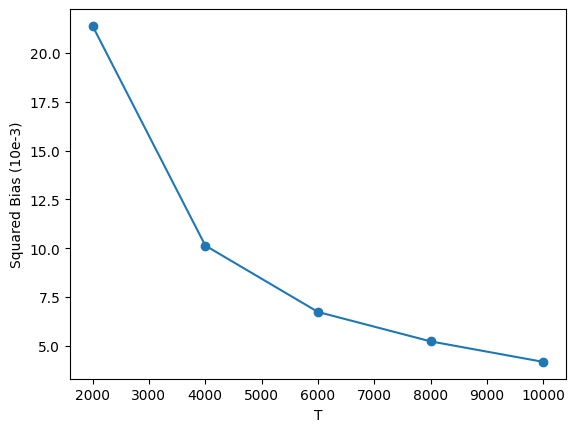

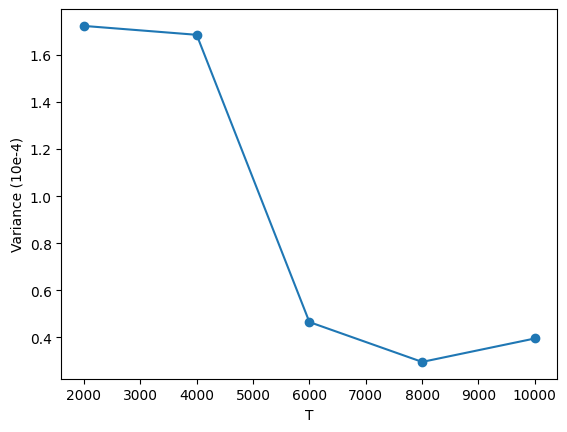

In [11]:
bias_squared = np.zeros(n_T)
var = np.zeros(n_T)
for i in range(n_T):
    t = T_list[i]
    error_list = main_MLR_estimate(y_list, A_list, ranks, inference_routine, t, show=True)
    bias_squared[i] = np.mean(error_list ** 2)
    var[i] = np.var(error_list)

plt.plot(T_list, 10 ** 3 * bias_squared)
plt.scatter(T_list, 10 ** 3 * bias_squared)
plt.ylabel('Squared Bias (10e-3)')
plt.xlabel('T')
plt.show()

plt.plot(T_list, 10 ** 4 * var)
plt.scatter(T_list, 10 ** 4 * var)
plt.ylabel('Variance (10e-4)')
plt.xlabel('T')
plt.show()

## The asymptotic convergence of the SHORR estimate

In [12]:
T = 2000  # Length of the time series
sigma = 1.0  # Variance of the innovations, assuming diagonal noise
ranks = [2, 2, 2]
s1, s2, s3 = 2, 2, 2
S = s1 * s2 * s3
n_sample = 10
N, P = 3, 2
y_list = np.zeros((n_sample, N, T))
A_list = np.zeros((n_sample, N, N, P))
E_list = np.zeros((n_sample, N, T))

## Creation of the dataset
for l in range(n_sample):
    while True:
        try:
            U1 = np.zeros((N, ranks[0]))  # Creation of sparse matrices
            a = np.random.normal(size=2)
            a /= np.linalg.norm(a)
            U1[:2, 0] = a
            U1[2, 1] = 1

            U2 = np.zeros((N, ranks[1]))
            b = np.random.normal(size=2)
            b /= np.linalg.norm(b)
            U2[:2, 0] = b
            U2[2, 1] = 1

            theta = np.random.rand() * 2 * np.pi
            U3 = np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta), np.cos(theta)]])

            G = generate_core_tensor(ranks)

            Us = [U1, U2, U3]
            A = ttm(G, Us)

            A = np.round(A, 8)

            cov = np.eye(N, ) * sigma
            y, A, E = generate(A, T, P, N, cov)

            break
        except RuntimeWarning:
            pass
        except AssertionError:
            pass
    y_list[l] = y
    A_list[l] = A
    E_list[l] = E

C:\Users\schoo\OneDrive\Bureau\Mines\Cours\3A\MVA\Semestre 1\Séries temporelles\Projet\project_git\high_dimensional_vector_autoregressive\hd_var\generate.py:26: RuntimeWarning: invalid value encountered in add
  y[:, t] += A[:, :, p] @ y[:, t - p - 1]


In [13]:
def main_SHORR_estimate(y_list, A_list, ranks, inference_routine, t, show=False):
    np.random.seed(0)
    n_sample, N, T = y_list.shape
    error_list = np.zeros(n_sample)

    for i in range(n_sample):
        y, A = y_list[i], A_list[i]
        y_reshaped = y[:, :t]
        P = A.shape[-1]
        A_init = generate_A_given_rank(N, P, ranks)
        res = inference_routine(A_init=A_init, ranks=ranks, y_ts=y_reshaped)
        error_list[i] = np.linalg.norm(res[1] - A)
        if (i / n_sample * 100) % 20 == 0 and show:
            print(i / n_sample * 100, "%")
    return error_list

0.015 done
0.03 done
0.045 done
0.06 done


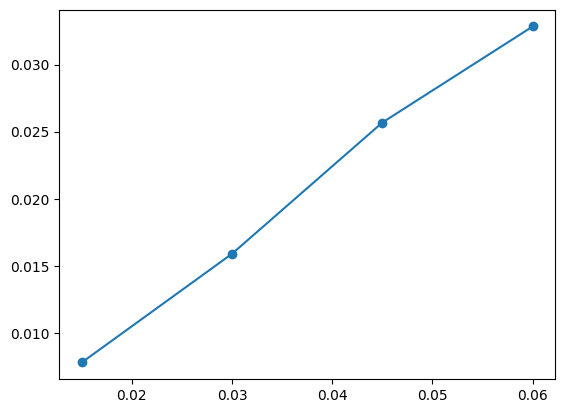

In [14]:
gamma = np.array([15, 30, 45, 60]) * 10 ** -3
n_gamma = len(gamma)
error = np.zeros(n_gamma)

for i in range(n_gamma):
    gam = gamma[i]
    t = int((S * np.log(P * (N ** 2))) / gam)
    error_list = main_SHORR_estimate(y_list, A_list, ranks, inference_routine, t, show=False)
    error[i] = np.mean(error_list ** 2)
    print(gam, 'done')

plt.plot(gamma, error * 1e3)
plt.scatter(gamma, error * 1e3)
plt.xlabel('gamma')
plt.ylabel('Squared Bias (10e-3)')

## Rank Selection performance

In [18]:
T = 400  # Length of the time series
sigma = 1.0  # Variance of the innovations, assuming diagonal noise
ranks = [2, 2, 2]
n_sample = 20
N, P = 4, 3

y_list = np.zeros((n_sample, N, T))
A_list = np.zeros((n_sample, N, N, P))
E_list = np.zeros((n_sample, N, T))

for i in range(n_sample):
    while True:
        try:
            A = generate_A_given_rank(N, P, ranks)
            N, P = A.shape[1:]
            cov = np.eye(N, ) * sigma
            y, A, E = generate(A, T, P, N, cov)
            break
        except RuntimeWarning:
            pass
        except AssertionError:
            pass
    y_list[i] = y
    A_list[i] = A
    E_list[i] = E

In [19]:
T_list = [100, 200, 300, 400]
n_T = len(T_list)
lam = 1e-2 * np.log(N * N * P)

ratio = np.zeros(n_T)

for i in range(n_T):
    t = T_list[i]
    rat = 0
    for j in range(n_sample):
        y = y_list[j]
        y_reshaped = y[:, :t]
        A_estimated_NN = NN_compute(y_reshaped[:, P:], P, lam)[0]
        ranks_estimated = rank_selection(A_estimated_NN, T)
        if np.all(ranks_estimated == ranks):
            rat += 1
    print(t)
    ratio[i] = rat / n_sample

100
200
300
400


Text(0, 0.5, 'Hit Ratio')

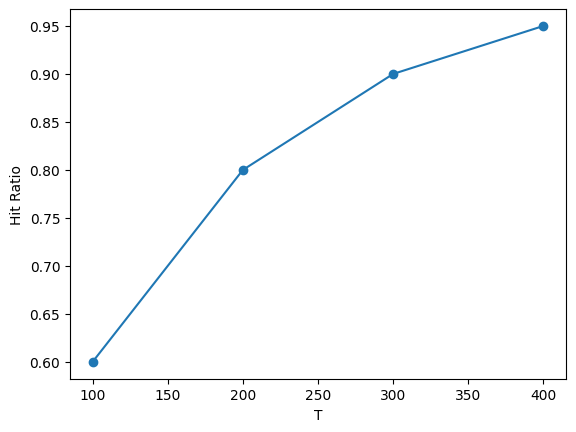

In [20]:
plt.plot(T_list, ratio)
plt.scatter(T_list, ratio)
plt.xlabel('T')
plt.ylabel('Hit Ratio')